# <center>AI / ML Project - Zinc Prices Forecast
#### <center> ***Domain: Manufacturing***

### Description:

A simple yet challenging project, to forecast the IMF commodity price of Zinc, based on monthly totals zinc price recorded from 1980 to 2016.

This data frame contains the following columns:

* Month : The month of observation
* Price : Average Prices of zinc in that particular month

## <center>1. Visualizing the Time Series

In [1]:
#Importing the basic librarires

import math
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime as dt
from IPython.display import display

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,8]

import warnings 
warnings.filterwarnings('ignore')

In [2]:
#Importing the dataset

df = pd.read_csv('datasets/zinc.csv')
variable='Price'
df.loc[:,'Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,Price
Date,
1980-01-01,773.82
1980-02-01,868.62
1980-03-01,740.75
1980-04-01,707.68
1980-05-01,701.07



Inference: The Datset consists of 1 features & 434 samples.


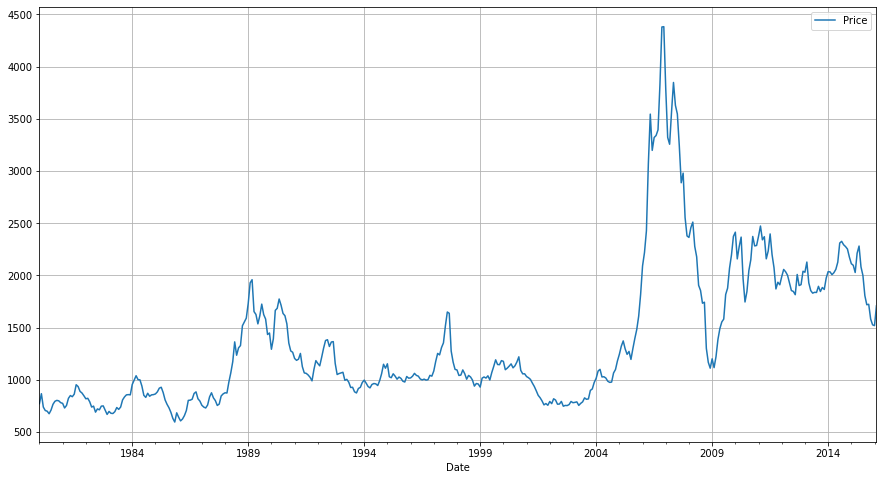

In [3]:
# Plotting the Timeseries

df.plot()
plt.grid()
plt.show()

**Inference:** It's clear from the plot that there is an uptrend in the volumne of Passengers, with some seasonality. Let us perform stationarity check using visual (rolling mean & std) & statistical tests ( Dicky-Fooler's Test) to confirm the same.

---

## <center>2. Stationarize the Series

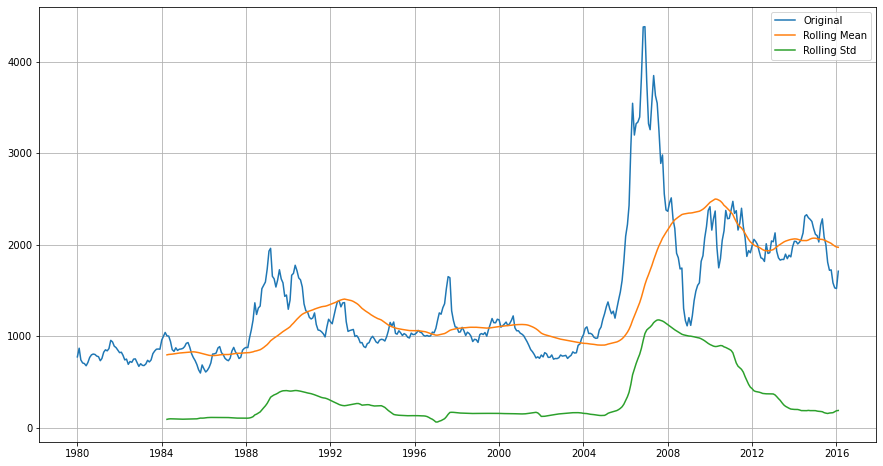

T Statistic            -3.139601
P-Value                 0.023758
#Lags Used              7.000000
#Observations Used    426.000000
Critical value 1%      -3.445794
Critical value 5%      -2.868349
Critical value 10%     -2.570397
dtype: float64


In [4]:
#Stationary Check

def Staionarity_Check(ts):
    plt.plot(ts, label='Original')
    plt.plot(ts.rolling(window=52, center=False).mean(), label='Rolling Mean')
    plt.plot(ts.rolling(window=52, center=False).std(), label='Rolling Std')
    plt.grid()
    plt.legend()
    plt.show()
    
    adf = adfuller(ts, autolag='AIC')
    padf = pd.Series(adf[:4], index=['T Statistic','P-Value','#Lags Used','#Observations Used'])
    for k,v in adf[4].items():
        padf['Critical value {}'.format(k)]=v
    print(padf)
    
Staionarity_Check(df[variable])

**Inference:** Since the test statistic is higher than the critical value, & the rolling mean is not constant over time, therefore the null hypothesis cannot be rejected. This implies that the time-series is non-staionary!
Let us fix this by decomposing using moving average...

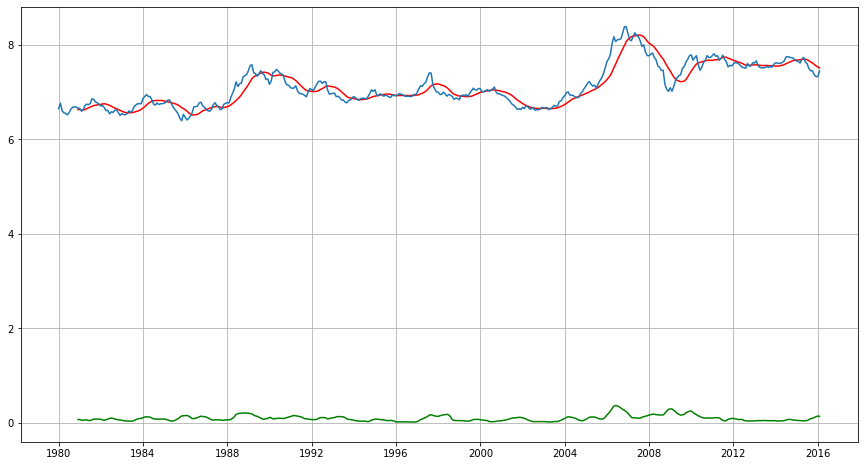

In [5]:
#Decomposing using moving average

tsl = np.log(df)
ma = tsl.rolling(window=12).mean()
ms = tsl.rolling(window=12).std()

plt.plot(ma, c='r')
plt.plot(ms, c='g')
plt.plot(tsl)
plt.grid()
plt.show()

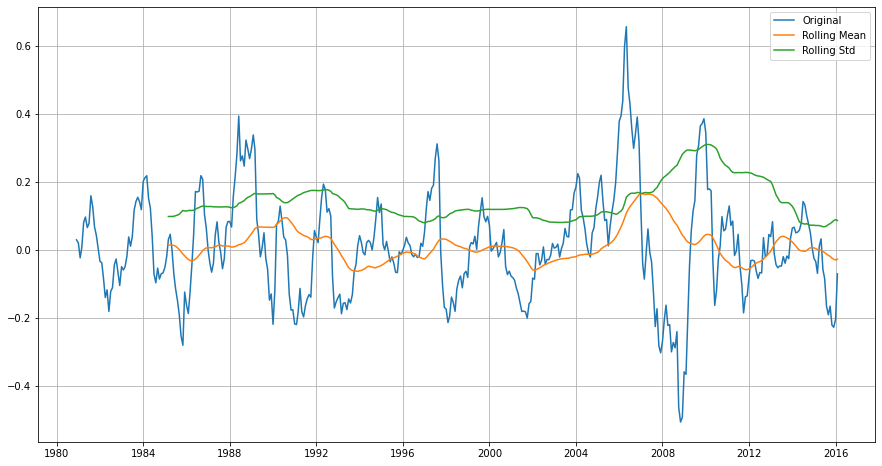

T Statistic          -5.898484e+00
P-Value               2.814411e-07
#Lags Used            4.000000e+00
#Observations Used    4.180000e+02
Critical value 1%    -3.446091e+00
Critical value 5%    -2.868479e+00
Critical value 10%   -2.570466e+00
dtype: float64


In [6]:
# Stationarity Check for Decomposed Time Series

tsl - np.log(df)
ma = tsl.rolling(window=12, center=False).mean()

tslma = tsl - ma
tslma = tslma.dropna()
Staionarity_Check(tslma)

**Inference**: Now the test staistic can be observed to be less that 5% critical value, hence the nullhypothsis can be rejected. Indicating that the time series is stationary & we can use it to create our ARIMA Model. But before that, let us find the parameters - `p` & `q` required by the model, by plotting Auto-Correlation Function & Partial Auto-Correlation Function.

---

## <center>3. Plotting ACF / PACF

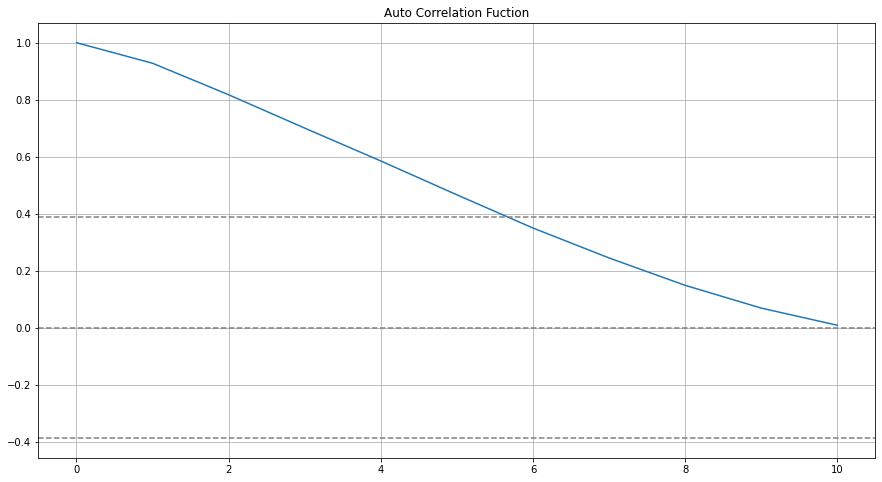

In [7]:
#Auto Correlation Fuction #q

plt.plot(np.arange(acf(tslma, nlags=10,fft=True).shape[0]),acf(tslma, nlags=10, fft=True))
plt.axhline(y=0, linestyle='--', c='gray')
plt.axhline(y=-7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')
plt.axhline(y=7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')

plt.title('Auto Correlation Fuction')
plt.grid()
plt.show()

**Inference:** The ACF Curve passes throught the upper confidence value when the lag value is between 5 & 6, hence the optimal value of `q` can be either 5 or 6.

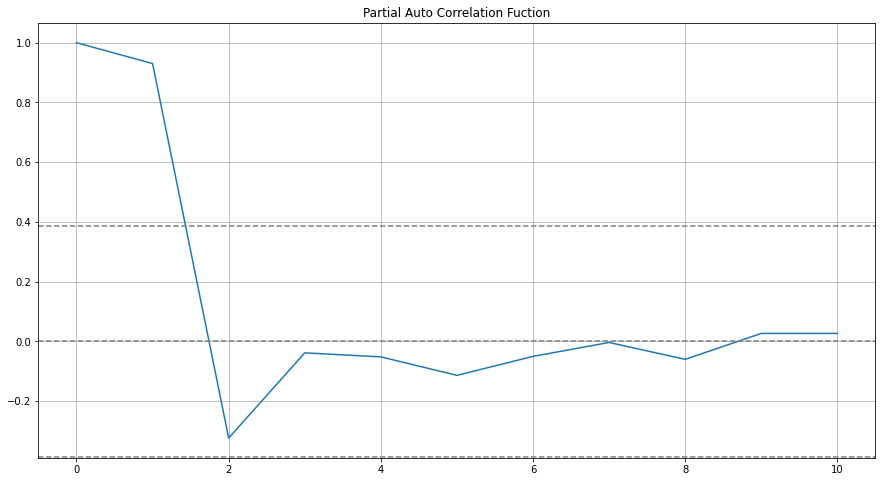

In [8]:
#Partial Auto Correlation Fuction #p

plt.plot(np.arange(pacf(tslma, nlags=10).shape[0]),pacf(tslma, nlags=10))
plt.axhline(y=0, linestyle='--', c='gray')
plt.axhline(y=-7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')
plt.axhline(y=7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')

plt.title('Partial Auto Correlation Fuction')
plt.grid()
plt.show()

**Inference:** The PACF Curve drops to 0 when the lag value is between 1 & 2, hence the optimal value of `p` can be either 1 or 2.

---

## <center>4. Model Building

In [9]:
#Building ARIMA Model

Arima = ARIMA(tslma, order=(2,5,1))
Ar = Arima.fit()
Ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  423
Model:                 ARIMA(2, 5, 1)   Log Likelihood                 267.664
Date:                Sat, 01 Jan 2022   AIC                           -527.328
Time:                        07:41:42   BIC                           -511.186
Sample:                    12-01-1980   HQIC                          -520.947
                         - 02-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0827      0.042    -25.852      0.000      -1.165      -1.001
ar.L2         -0.5279      0.039    -13.607      0.000      -0.604      -0.452
ma.L1         -0.9972      0.168     -5.933      0.000      -1.327      -0.668
sigma2         0.0159      0.003      5.611      0.000       0.010       0.021
===================================================================================
Ljung-Box (L1) (Q):                  25.69   Jarque-Bera (JB):                23.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                             0.12
Prob(H) (two-sided):                  0.21   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Inference:** The Arima Model fits well on the time-series data with nearly perfect p-values. Let us now forcast the future data with the help of the trained ARIMA Model.

---

## <center>5. Forecasting

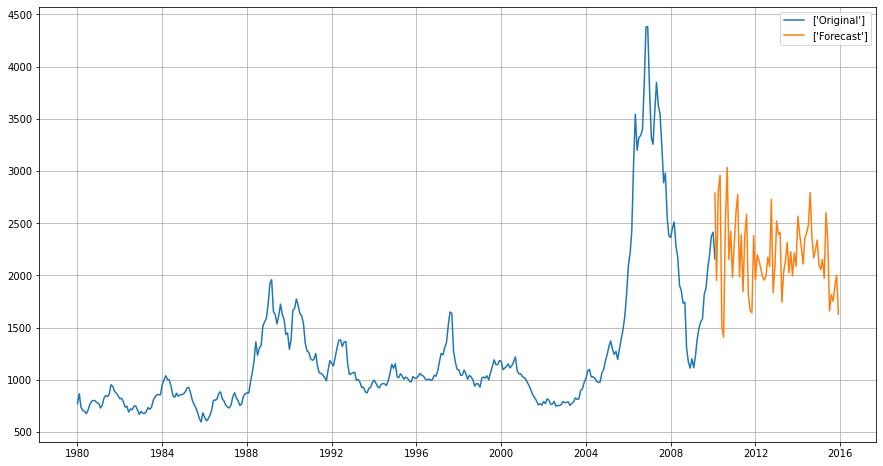

In [10]:
# Forecasting future predictions

future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_datest_df.tail()

future_df=pd.concat([df,future_datest_df])

future_df['a'] = Ar.predict(start =350, end = 420, dynamic= False)

plt.plot(future_df[variable][:-95], label=['Original'])
plt.plot(np.exp(future_df['a']+(1.08*ma.mean()[0])), label=['Forecast'])
plt.grid()
plt.legend()
plt.show()

**Inference:**<br>
The model's forecast seems to be precise as it captures most of the sesonality & possible trends in the time-series data.


In [11]:
#<<<------------------------------------- THE END ----------------------------------------------->>>